<a href="https://colab.research.google.com/github/FarrelEdric/PembelajaranMesin_2024/blob/main/UTS_kel3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Network for Face Recognition

Kelompok 3:
- Fransiscus Farrel Edric Wijanarko (2241720032)

## Persiapan Data

Mengambil dataset dari kagglehub

In [ ]:
import kagglehub
import numpy as np
import os
import shutil
import tensorflow as tf

# Pastikan dataset CASIA-Webface telah diunduh di direktori yang benar
path = kagglehub.dataset_download("ntl0601/casia-webface")

destination_path = "/content/casia-webface/"

# Cek jika direktori tujuan ada, jika tidak buatlah
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

# Pindahkan semua file dari folder download ke folder sample_data
for filename in os.listdir(path):
    shutil.move(os.path.join(path, filename), os.path.join(destination_path, filename))

print("Path to dataset files:", destination_path)


100%|██████████| 2.53G/2.53G [00:10<00:00, 255MB/s]

Extracting files...


## Load Data

Melakukan load data dengan minimum face nya adalah 40 dan maksimal face nya adalah 80, ambil 1000 org pertama

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from collections import Counter

def load_data(data_dir, target_size=(128, 128), min_images_per_person=100, max_images_per_person=100, max_persons=5000):
    data = []
    label_map = {}  # Untuk memetakan nama folder ke angka
    images_per_label = Counter()  # Untuk menghitung jumlah gambar per label

    # Mendapatkan semua folder (misalnya 00001, 00002, ...)
    person_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

    # Memproses maksimal 2000 folder (orang)
    person_folders = person_folders[:max_persons]

    # Memproses setiap folder
    for idx, person in enumerate(person_folders):
        person_path = os.path.join(data_dir, person)
        img_files = [f for f in os.listdir(person_path) if f.endswith('.jpg')]

        # Jika jumlah gambar kurang dari min_images_per_person, abaikan folder tersebut
        if len(img_files) < min_images_per_person:
            continue

        img_count = 0  # Inisialisasi penghitung gambar per orang

        # Berikan nomor label berdasarkan urutan folder
        label_map[person] = idx

        # Memuat gambar dari folder tersebut
        for img_file in img_files[:max_images_per_person]:  # Ambil maksimal 50 gambar
            img_path = os.path.join(person_path, img_file)

            # Memuat gambar dan mengubah ukurannya
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            img_array = img_array / 255.0  # Normalisasi antara 0 dan 1

            # Gabungkan gambar dan label ke dalam satu array
            data.append((img_array, idx))  # idx adalah label yang sudah diubah jadi angka

            img_count += 1  # Tambah penghitung gambar
            images_per_label[idx] += 1  # Tambah penghitung jumlah gambar per label

            # Jika sudah mencapai max_images_per_person, berhenti mengambil gambar
            if img_count >= max_images_per_person:
                break

    # Mengonversi ke array NumPy (hanya bagian gambar)
    images_array = np.array([img for img, _ in data])
    labels_array = np.array([label for _, label in data])

    return images_array, labels_array, images_per_label

# Path ke dataset
data_directory = '/content/casia-webface/casia-webface'

# Memuat data dengan minimal 30 gambar per orang dan maksimal 50 gambar per orang, serta maksimal 2000 orang
images, labels, images_per_label = load_data(data_directory)

print("Shape of images array:", images.shape)
print("Shape of labels array:", labels.shape)

# Menampilkan jumlah data per label
for label, count in images_per_label.items():
    print(f"Label {label}: {count} images")


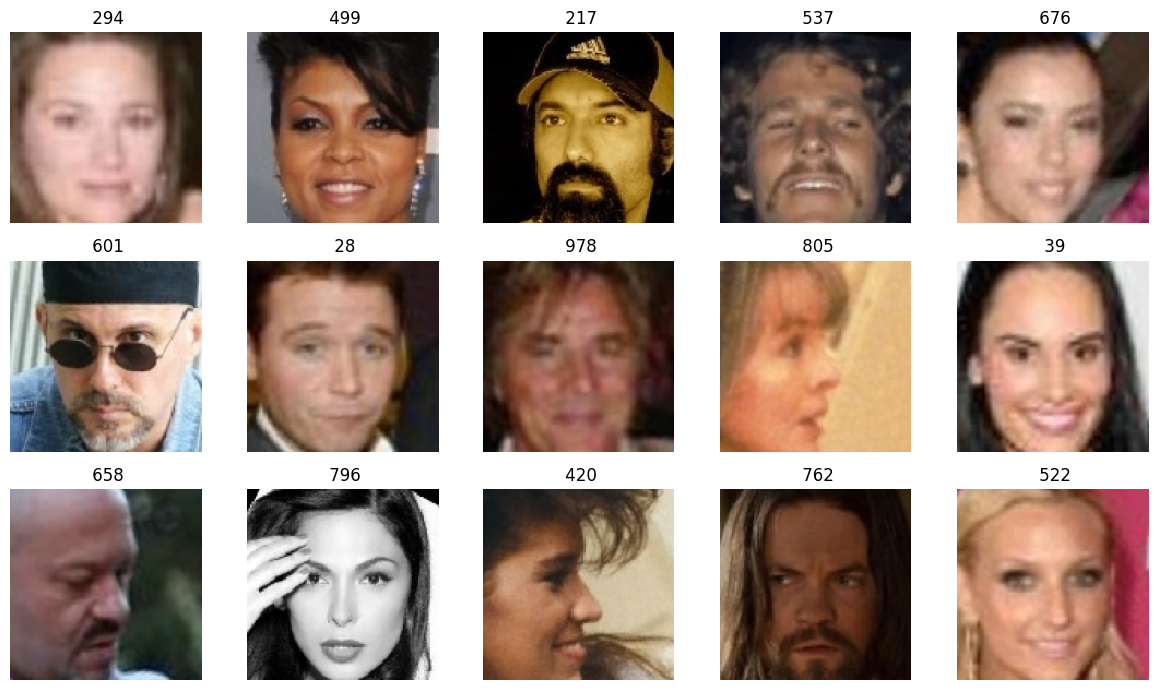

In [ ]:
from random import sample
import matplotlib.pyplot as plt

random_indices = sample(range(images.shape[0]), 15)

plt.figure(figsize=(12, 7))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[idx], cmap='bone')
    plt.title(f' {labels[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print("Jumlah Orang: ", len(np.unique(labels)))

Jumlah Orang:  467


## Ekstrasi Fitur dan Melakukan Encode terhadap Label

In [ ]:
from skimage.feature import hog
from skimage import color
import numpy as np

def extract_features_hog(image_array, labels, batch_size, target_size):
    all_features = []
    all_labels = []
    total_images = len(image_array)

    print("Memulai ekstraksi fitur HOG...")

    for i in range(0, total_images, batch_size):
        batch_images = image_array[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]

        # Load dan preprocess batch gambar
        batch_features = []
        valid_labels = []

        for img, label in zip(batch_images, batch_labels):
            # Resize jika ukuran tidak sesuai target size
            if img.shape[:2] != target_size:
                img = resize(img, target_size)

            # Convert to grayscale
            gray_img = color.rgb2gray(img)
            # Extract HOG features (tanpa visualisasi untuk menghemat waktu)
            features = hog(gray_img,
                           pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2),
                           feature_vector=True)  # Set visualize=False by default
            batch_features.append(features)
            valid_labels.append(label)

        if batch_features:
            all_features.extend(batch_features)
            all_labels.extend(valid_labels)

        # Print progress
        print(f"Processed {min(i + batch_size, total_images)}/{total_images} images")

    return np.array(all_features), np.array(all_labels)

# Contoh pemanggilan fungsi
# Anggap `images` adalah array yang berisi gambar dan `labels` adalah array yang berisi label
features, label_hog = extract_features_hog(images, labels, 32, (128, 128))

print("Bentuk fitur HOG:", features.shape)
print("Bentuk label:", label_hog.shape)

Memulai ekstraksi fitur HOG...
Processed 32/46700 images
Processed 64/46700 images
Processed 96/46700 images
Processed 128/46700 images
Processed 160/46700 images
Processed 192/46700 images
Processed 224/46700 images
Processed 256/46700 images
Processed 288/46700 images
Processed 320/46700 images
Processed 352/46700 images
Processed 384/46700 images
Processed 416/46700 images
Processed 448/46700 images
Processed 480/46700 images
Processed 512/46700 images
Processed 544/46700 images
Processed 576/46700 images
Processed 608/46700 images
Processed 640/46700 images
Processed 672/46700 images
Processed 704/46700 images
Processed 736/46700 images
Processed 768/46700 images
Processed 800/46700 images
Processed 832/46700 images
Processed 864/46700 images
Processed 896/46700 images
Processed 928/46700 images
Processed 960/46700 images
Processed 992/46700 images
Processed 1024/46700 images
Processed 1056/46700 images
Processed 1088/46700 images
Processed 1120/46700 images
Processed 1152/46700 im

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label encoding
le = LabelEncoder()
labels_encoded = le.fit_transform(label_hog)

## Split Data

Membagi data menjadi 80% training, 10% validation, 10% test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## Build Model

### Membuat model PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=600, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

### Membuat Model ANN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import numpy as np

num_classes = len(np.unique(labels_encoded))  # Hitung jumlah kelas

# Build CNN model for image classification
def build_ann_model(input_shape):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(num_classes, activation='softmax'))  # Gunakan softmax untuk klasifikasi multi-kelas

    # Compile model
    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model = build_ann_model(X_train_pca.shape[1])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Training
history = model.fit(
    X_train_pca, y_train,
    epochs=50,
    validation_data=(X_val_pca, y_val),  # Gunakan validation_data, bukan validation_split
    callbacks=callbacks
)

# Evaluasi model CNN pada data validasi
val_loss, val_accuracy = history.model.evaluate(X_val_pca, y_val)
print(f"Accuracy on validation set (CNN only): {val_accuracy * 100:.2f}%")

Epoch 1/50
1168/1168 [==============================] - 8s 6ms/step - loss: 5.3653 - accuracy: 0.0667 - val_loss: 4.0107 - val_accuracy: 0.2662 - lr: 0.0010
Epoch 2/50
1168/1168 [==============================] - 6s 6ms/step - loss: 3.7825 - accuracy: 0.2581 - val_loss: 2.9864 - val_accuracy: 0.4310 - lr: 0.0010
Epoch 3/50
1168/1168 [==============================] - 7s 6ms/step - loss: 3.1102 - accuracy: 0.3696 - val_loss: 2.6308 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 4/50
1168/1168 [==============================] - 7s 6ms/step - loss: 2.7760 - accuracy: 0.4266 - val_loss: 2.4740 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 5/50
1168/1168 [==============================] - 7s 6ms/step - loss: 2.5611 - accuracy: 0.4619 - val_loss: 2.3889 - val_accuracy: 0.5407 - lr: 0.0010
Epoch 6/50
1168/1168 [==============================] - 7s 6ms/step - loss: 2.3978 - accuracy: 0.4922 - val_loss: 2.3176 - val_accuracy: 0.5471 - lr: 0.0010
Epoch 7/50
1168/1168 [==============================] - 7s

## Evaluasi Model

In [ ]:
# Evaluasi model CNN pada data test
test_loss, test_accuracy = history.model.evaluate(X_train_pca, y_train)
print(f"Accuracy on test set (ANN only): {test_accuracy * 100:.2f}%")
# Evaluasi model CNN pada data test
test_loss, test_accuracy = history.model.evaluate(X_test_pca, y_test)
print(f"Accuracy on test set (ANN only): {test_accuracy * 100:.2f}%")

1168/1168 [==============================] - 3s 2ms/step - loss: 0.2326 - accuracy: 0.9682
Accuracy on test set (ANN only): 96.82%
146/146 [==============================] - 0s 2ms/step - loss: 2.1279 - accuracy: 0.6017
Accuracy on test set (ANN only): 60.17%
